In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

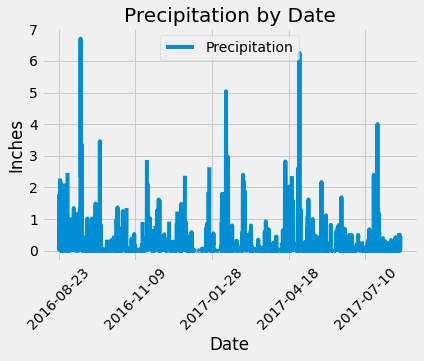

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
first_row = session.query(measurement).first()
first_row.__dict__
# Lastest date = 2017-08-23
# Calculate the date 1 year ago from the last data point in the database
lastest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
oneyear_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Date one year ago = 2016-08-23

# Perform a query to retrieve the data and precipitation scores
oneyear_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= oneyear_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(oneyear_data,columns=["Date","Precipitation"]).set_index("Date")
prcp_df
# Sort the dataframe by date
prcp_sorted = prcp_df.sort_values(['Date'],ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
prcp_sorted.plot(rot=45,title="Precipitation by Date",ylabel="Inches")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = prcp_sorted.describe()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations_no = session.query(func.count(station.station)).all()
stations_no

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# Most active station = USC00519281
temp_stats = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
temp_stats

[(54.0, 85.0, 71.66378066378067)]

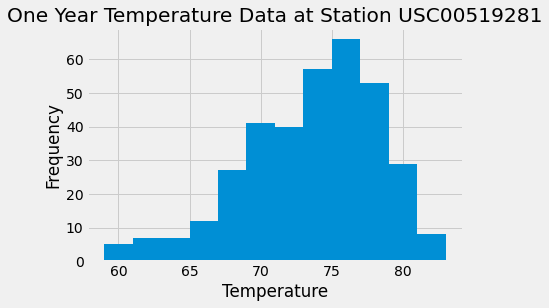

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
busiest_station = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281', measurement.date >= oneyear_date).all()
temp_values = list(np.ravel(busiest_station))
plt.hist(temp_values, bins=12)
plt.title("One Year Temperature Data at Station USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [17]:
session.close()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2015-11-17', '2015-11-24')
trip_temps

[(66.0, 74.0, 81.0)]

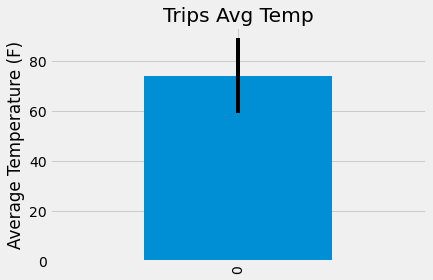

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temps_df = pd.DataFrame(trip_temps, columns=["min","avg","max"])
avg_value = temps_df["avg"]
yerr_temp = temps_df["max"] - temps_df["min"]
avg_value.plot(kind='bar',yerr=yerr_temp)
plt.ylabel("Average Temperature (F)")
plt.title("Trips Avg Temp")
plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the stamtion, nae, latitude, longitude, and elevation

sel = [station.name,station.station,station.latitude,station.longitude,station.elevation,measurement.station,measurement.prcp]

rainfall_data = session.query(*sel).filter(station.station == measurement.station,measurement.date >= '2015-11-17',measurement.date <= '2015-11-24').\
    order_by(measurement.prcp.desc()).all()
rainfall_data


[('MANOA LYON ARBO 785.2, HI US',
  'USC00516128',
  21.3331,
  -157.8025,
  152.4,
  'USC00516128',
  3.38),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  'USC00519523',
  21.33556,
  -157.71139,
  19.5,
  'USC00519523',
  2.3),
 ('WAIHEE 837.5, HI US',
  'USC00519281',
  21.45167,
  -157.84888999999998,
  32.9,
  'USC00519281',
  2.17),
 ('MANOA LYON ARBO 785.2, HI US',
  'USC00516128',
  21.3331,
  -157.8025,
  152.4,
  'USC00516128',
  1.97),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  21.5213,
  -157.8374,
  7.0,
  'USC00514830',
  1.92),
 ('WAIHEE 837.5, HI US',
  'USC00519281',
  21.45167,
  -157.84888999999998,
  32.9,
  'USC00519281',
  1.87),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  'USC00519523',
  21.33556,
  -157.71139,
  19.5,
  'USC00519523',
  1.84),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  21.5213,
  -157.8374,
  7.0,
  'USC00514830',
  1.75),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  'USC00519523',
  21.33556,
  -157.71139,
  19.5

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = "11-17-2016"
end_date = "11-24-2016"
# Use the start and end date to create a range of dates
dateranges = pd.date_range(start=start_date,end=end_date)
# Strip off the year and save a list of %m-%d strings
md_dates = dateranges.strftime("%m-%d")
# Loop through the list of %m-%d strings and calculate the normals for each date
for dates in md_dates:
    normals.append(tuple(np.ravel(daily_normals(dates))))
normals    

[(64.0, 72.6923076923077, 79.0),
 (66.0, 73.55319148936171, 81.0),
 (64.0, 73.08333333333333, 81.0),
 (67.0, 73.03921568627452, 80.0),
 (66.0, 73.34, 81.0),
 (65.0, 71.98, 80.0),
 (64.0, 72.2, 80.0),
 (66.0, 72.56521739130434, 77.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trips_df = pd.DataFrame(normals,columns = ["Min","Avg","Max"])
trips_df["Dates"] = dateranges
trips_df = trips_df.set_index("Dates")
trips_df

,Min,Avg,Max
Dates,,,
2016-11-17,64.0,72.692308,79.0
2016-11-18,66.0,73.553191,81.0
2016-11-19,64.0,73.083333,81.0
2016-11-20,67.0,73.039216,80.0
2016-11-21,66.0,73.340000,81.0
2016-11-22,65.0,71.980000,80.0
2016-11-23,64.0,72.200000,80.0
2016-11-24,66.0,72.565217,77.0


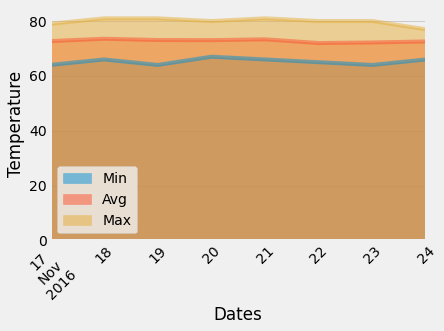

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
trips_df.plot.area(stacked=False,rot=45)
plt.ylabel("Temperature")
plt.show()

In [ ]:
session.close()